In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 194.86it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 189.17it/s]


In [7]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [8]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [9]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [10]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

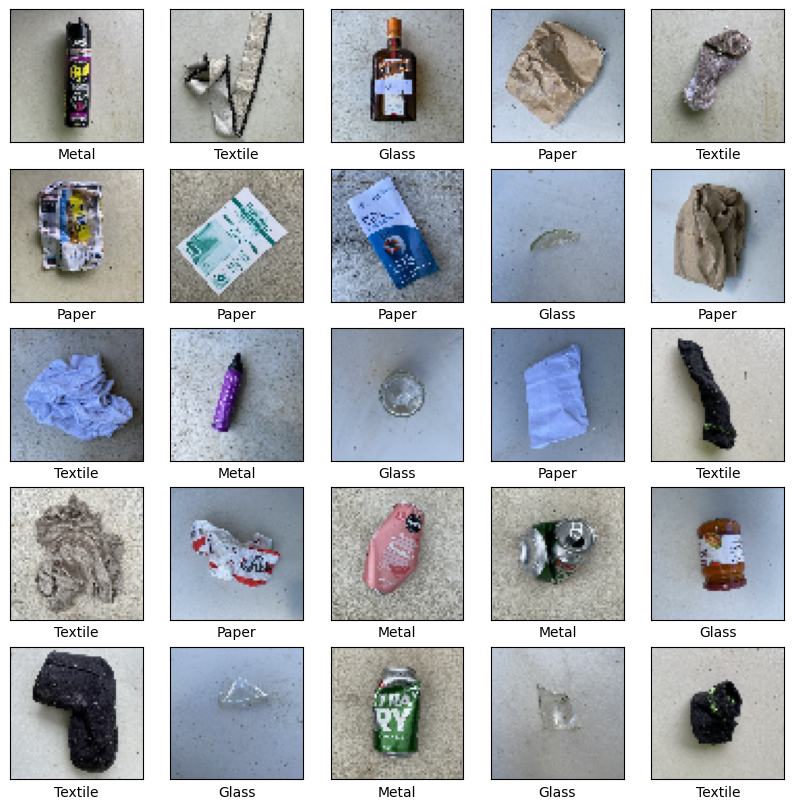

In [11]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
#Sequential Model 1
# Experience 10 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    #Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')     
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,444 (1.61 MB)

 Trainable params: 421,444 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
       
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')   
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,756 (1.14 MB)

 Trainable params: 298,756 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,300 (919.14 KB)

 Trainable params: 235,300 (919.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [16]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [17]:
#Exponential decay for learning rate

def scheduler(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [18]:
# Set number of epochs

epochs = 100
batch_size = 64

In [19]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback, model_checkpoint_callback1])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time )


Time model start: 2024-11-07 21:52:58.530418

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2867 - loss: 1.4016
Epoch 1: val_accuracy improved from -inf to 0.39352, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2889 - loss: 1.3992 - val_accuracy: 0.3935 - val_loss: 1.3567 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4584 - loss: 1.3020
Epoch 2: val_accuracy improved from 0.39352 to 0.52315, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4582 - loss: 1.3006 - val_accuracy: 0.5231 - val_loss: 1.2126 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7501 - loss: 0.6044 - val_accuracy: 0.6806 - val_loss: 0.7981 - learning_rate: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7633 - loss: 0.6021
Epoch 19: val_accuracy improved from 0.68519 to 0.69907, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7654 - loss: 0.5969 - val_accuracy: 0.6991 - val_loss: 0.7605 - learning_rate: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7971 - loss: 0.5320
Epoch 20: val_accuracy improved from 0.69907 to 0.70833, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7915 - loss: 0.5371 - val_accuracy: 0.7083 - val_loss: 0.7731 - learning_rate: 0.0010

Epoch 21: LearningRateS


Epoch 37: LearningRateScheduler setting learning rate to 0.000735091819660738.
Epoch 37/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9057 - loss: 0.2657
Epoch 37: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9054 - loss: 0.2664 - val_accuracy: 0.7500 - val_loss: 0.6923 - learning_rate: 7.3509e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006983372120885178.
Epoch 38/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9272 - loss: 0.2361
Epoch 38: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9255 - loss: 0.2390 - val_accuracy: 0.7546 - val_loss: 0.7122 - learning_rate: 6.9834e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9090 - loss: 0.2506
Epoch 39: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0


Epoch 56: LearningRateScheduler setting learning rate to 0.00027738953212974593.
Epoch 56/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9618 - loss: 0.1317
Epoch 56: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9622 - loss: 0.1346 - val_accuracy: 0.7454 - val_loss: 0.6772 - learning_rate: 2.7739e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9540 - loss: 0.1617
Epoch 57: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9540 - loss: 0.1613 - val_accuracy: 0.7500 - val_loss: 0.6869 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9562 - loss: 0.1474
Epoch 58: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy:


Epoch 75: LearningRateScheduler setting learning rate to 0.00010467393149156123.
Epoch 75/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9735 - loss: 0.1131
Epoch 75: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9735 - loss: 0.1126 - val_accuracy: 0.7546 - val_loss: 0.7391 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9717 - loss: 0.1089
Epoch 76: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9715 - loss: 0.1089 - val_accuracy: 0.7546 - val_loss: 0.7339 - learning_rate: 9.9440e-05

Epoch 77: LearningRateScheduler setting learning rate to 9.446822441532275e-05.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9745 - loss: 0.0930
Epoch 77: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy:


Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9736 - loss: 0.1030
Epoch 94: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9737 - loss: 0.1034 - val_accuracy: 0.7546 - val_loss: 0.7348 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9829 - loss: 0.1169
Epoch 95: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9823 - loss: 0.1160 - val_accuracy: 0.7500 - val_loss: 0.7382 - learning_rate: 3.7524e-05

Epoch 96: LearningRateScheduler setting learning rate to 3.564792586985277e-05.
Epoch 96/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9837 - loss: 0.1025
Epoch 96: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 

In [20]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback2])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time )

Time model start: 2024-11-07 21:53:45.595040

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2335 - loss: 1.4231
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.2345 - loss: 1.4219 - val_accuracy: 0.2361 - val_loss: 1.3825 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2590 - loss: 1.3798
Epoch 2: val_accuracy improved from 0.23611 to 0.42130, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.2591 - loss: 1.3797 - val_accuracy: 0.4213 - val_loss: 1.3730 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7323 - loss: 0.5899 - val_accuracy: 0.7176 - val_loss: 0.6479 - learning_rate: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7954 - loss: 0.5463
Epoch 19: val_accuracy improved from 0.71759 to 0.72685, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7947 - loss: 0.5468 - val_accuracy: 0.7269 - val_loss: 0.6963 - learning_rate: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7804 - loss: 0.5631
Epoch 20: val_accuracy improved from 0.72685 to 0.73611, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7812 - loss: 0.5611 - val_accuracy: 0.7361 - val_loss: 0.6211 - learning_rate: 0.0010

Epoch 21: Learning


Epoch 55: LearningRateScheduler setting learning rate to 0.00029198898118920624.
Epoch 55/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9728 - loss: 0.0762
Epoch 55: val_accuracy improved from 0.84722 to 0.85648, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9729 - loss: 0.0762 - val_accuracy: 0.8565 - val_loss: 0.4794 - learning_rate: 2.9199e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.00027738953212974593.
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9756 - loss: 0.0652
Epoch 56: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9760 - loss: 0.0647 - val_accuracy: 0.8287 - val_loss: 0.4912 - learning_rate: 2.7739e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9759 - loss: 0.0742
Epoch 57: val_accuracy did not improve 


Epoch 74: LearningRateScheduler setting learning rate to 0.00011018308869097381.
Epoch 74/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9918 - loss: 0.0329
Epoch 74: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9917 - loss: 0.0330 - val_accuracy: 0.8472 - val_loss: 0.5103 - learning_rate: 1.1018e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.00010467393149156123.
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9775 - loss: 0.0616
Epoch 75: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9778 - loss: 0.0610 - val_accuracy: 0.8565 - val_loss: 0.5120 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9925 - loss: 0.0303
Epoch 76: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - ac


Epoch 93: LearningRateScheduler setting learning rate to 4.1577981755835934e-05.
Epoch 93/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9930 - loss: 0.0289
Epoch 93: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9928 - loss: 0.0291 - val_accuracy: 0.8426 - val_loss: 0.5059 - learning_rate: 4.1578e-05

Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9928 - loss: 0.0281
Epoch 94: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9927 - loss: 0.0282 - val_accuracy: 0.8333 - val_loss: 0.5251 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9938 - loss: 0.0298
Epoch 95: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - acc

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback3])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-07 21:57:03.988442

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2333 - loss: 1.4117
Epoch 1: val_accuracy improved from -inf to 0.32870, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.2337 - loss: 1.4109 - val_accuracy: 0.3287 - val_loss: 1.3855 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2764 - loss: 1.3860
Epoch 2: val_accuracy did not improve from 0.32870
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.2757 - loss: 1.3859 - val_accuracy: 0.2824 - val_loss: 1.3856 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2855 - loss: 1.3789
Epoch 3: val_ac


Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7034 - loss: 0.7063
Epoch 19: val_accuracy did not improve from 0.68519
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.7030 - loss: 0.7080 - val_accuracy: 0.6435 - val_loss: 0.8811 - learning_rate: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7017 - loss: 0.7264
Epoch 20: val_accuracy did not improve from 0.68519
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.7019 - loss: 0.7254 - val_accuracy: 0.6574 - val_loss: 0.8288 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7194 - loss: 0.6847
Epoch 21: val_accuracy did not improve from 0.68519
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9609 - loss: 0.1221 - val_accuracy: 0.7685 - val_loss: 0.6942 - learning_rate: 2.9199e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.00027738953212974593.
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9732 - loss: 0.0873
Epoch 56: val_accuracy did not improve from 0.78704
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9727 - loss: 0.0878 - val_accuracy: 0.7685 - val_loss: 0.7124 - learning_rate: 2.7739e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9722 - loss: 0.0846
Epoch 57: val_accuracy did not improve from 0.78704
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9720 - loss: 0.0848 - val_accuracy: 0.7731 - val_loss: 0.6989 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0

Epoch 93/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9811 - loss: 0.0506
Epoch 93: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9812 - loss: 0.0504 - val_accuracy: 0.7917 - val_loss: 0.7702 - learning_rate: 4.1578e-05

Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9820 - loss: 0.0605
Epoch 94: val_accuracy improved from 0.79167 to 0.79630, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9818 - loss: 0.0606 - val_accuracy: 0.7963 - val_loss: 0.7550 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9778 - loss: 0.0561
Epoch 95: val_accuracy did not improve from 0.79630
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9778 - loss: 0.

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:2.2)')

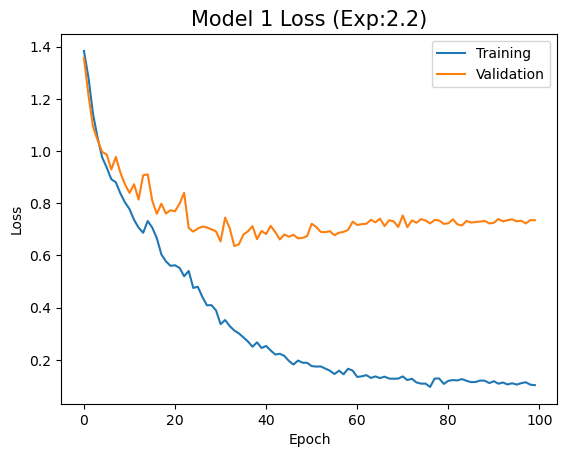

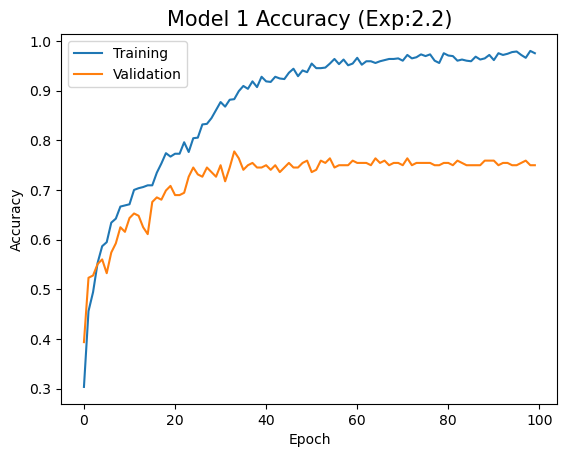

In [22]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:2.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:2.2)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy Exp:2.2')

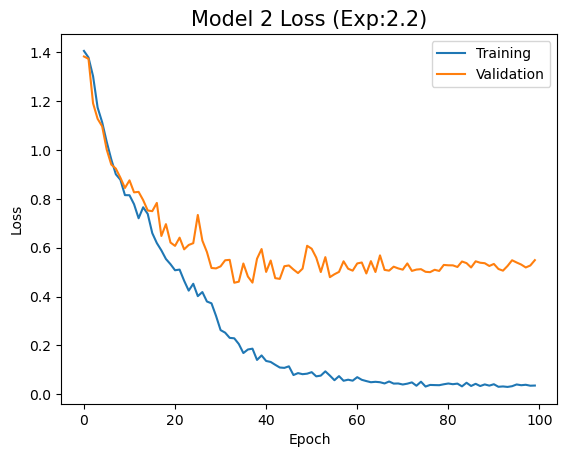

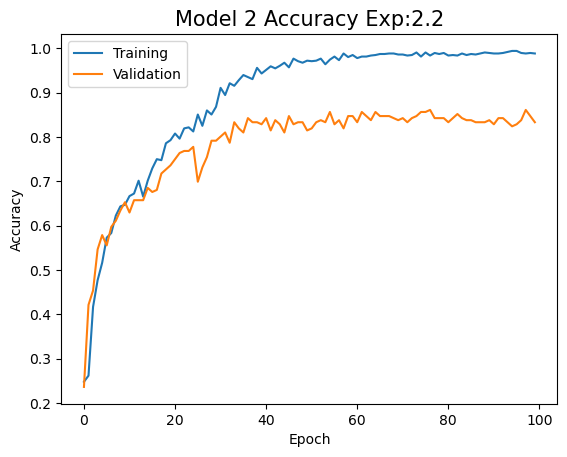

In [23]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:2.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy Exp:2.2', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:2.2)')

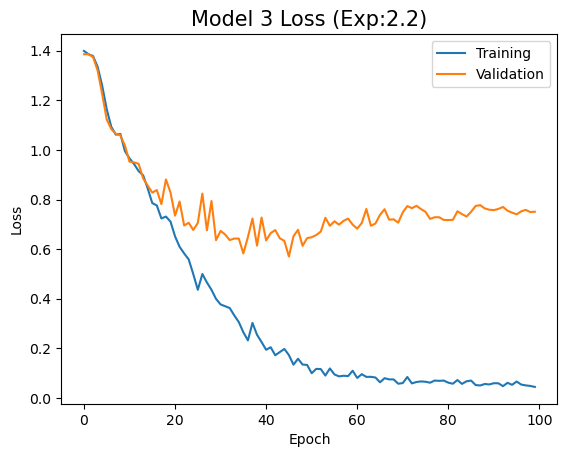

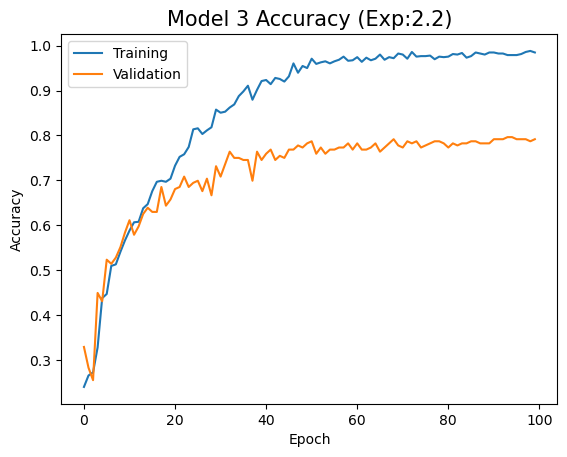

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:2.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:2.2)', fontsize = 15)

In [25]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7001 - loss: 0.7899 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7914 - loss: 0.6647
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8254 - loss: 0.6742


In [26]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [27]:
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [28]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


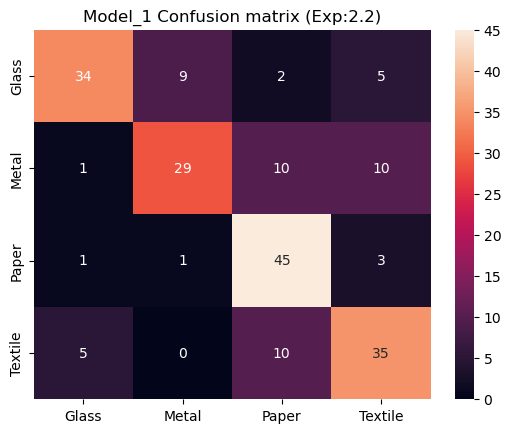

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_1 Confusion matrix (Exp:2.2)')
plt.show()


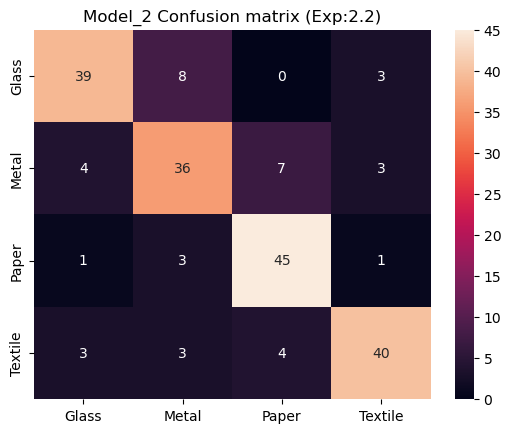

In [30]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_2 Confusion matrix (Exp:2.2)')
plt.show()



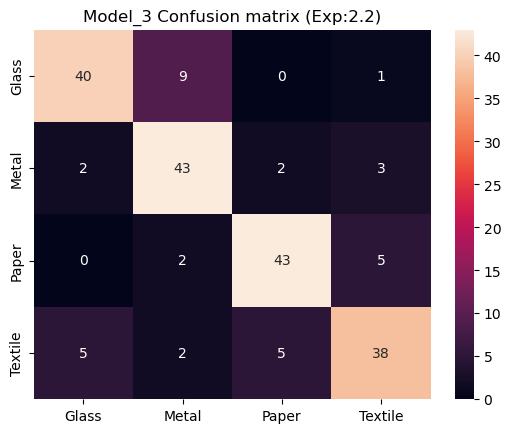

In [31]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_3 Confusion matrix (Exp:2.2)')
plt.show()

